In [299]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, precision_recall_curve

In [300]:
def extract_metrics(y_true, y_pred, y_proba):
    report = classification_report(y_true, y_pred, output_dict=True)
    return {
        "AUC": roc_auc_score(y_true, y_proba),
        "Precision": report['weighted avg']['precision'],
        "Recall": report['weighted avg']['recall'],
        "F1-Score": report['weighted avg']['f1-score']
    }

In [301]:
def load_and_merge_data():
    client_df = pd.read_csv('mkdir_data/client_data.csv')
    price_df = pd.read_csv('mkdir_data/price_data.csv')

    price_df['price_date'] = pd.to_datetime(price_df['price_date'])

    # Aggregated price data (average)
    avg_prices = price_df.groupby('id').mean(numeric_only=True).reset_index()
    df_avg = pd.merge(client_df, avg_prices, on='id')

    # Latest price data
    latest_prices = price_df.sort_values('price_date').drop_duplicates('id', keep='last')
    df_latest = pd.merge(client_df, latest_prices, on='id')

    return df_avg, df_latest



In [302]:
def engineer_features(df):
    df = df.copy()
    df['price_per_unit_energy_peak'] = df['price_peak_fix'] / (df['cons_12m'] + 1e-6)
    df['price_spread'] = df['price_peak_fix'] - df['price_off_peak_fix']
    df['price_sensitivity_score'] = df['price_spread'] * df['price_per_unit_energy_peak']
    return df

In [303]:
def extract_metrics(y_true, y_pred, y_proba):
    report = classification_report(y_true, y_pred, output_dict=True)
    return {
        "AUC": roc_auc_score(y_true, y_proba),
        "AUPRC": average_precision_score(y_true, y_proba),
        "Precision": report['weighted avg']['precision'],
        "Recall": report['weighted avg']['recall'],
        "F1-Score": report['weighted avg']['f1-score']
    }

In [304]:
def train_and_evaluate(df, label=''):
    features = ['price_per_unit_energy_peak', 'price_spread', 'price_sensitivity_score']
    target = 'churn'

    df = df.dropna(subset=features + [target])
    X = df[features]
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n=== {label} Model Evaluation ===")
    print(classification_report(y_test, y_pred))
    print("AUC Score:", roc_auc_score(y_test, y_proba))

    return extract_metrics(y_test, y_pred, y_proba)

def main():
    df_avg, df_latest = load_and_merge_data()

    df_avg = engineer_features(df_avg)
    df_latest = engineer_features(df_latest)

    metrics_avg = train_and_evaluate(df_avg, label="Average Price")
    metrics_latest = train_and_evaluate(df_latest, label="Latest Price")

    # Summary table
    results_df = pd.DataFrame([
        {"Model": "Average Price", **metrics_avg},
        {"Model": "Latest Price", **metrics_latest}
    ])
    print("\n=== Model Performance Comparison ===")
    print(results_df.to_string(index=False))

if __name__ == "__main__":
    main()


=== Average Price Model Evaluation ===
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      2617
           1       0.21      0.05      0.08       305

    accuracy                           0.88      2922
   macro avg       0.56      0.51      0.51      2922
weighted avg       0.83      0.88      0.85      2922

AUC Score: 0.5442654271879327

=== Latest Price Model Evaluation ===
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      2617
           1       0.17      0.07      0.10       305

    accuracy                           0.87      2922
   macro avg       0.54      0.52      0.51      2922
weighted avg       0.82      0.87      0.84      2922

AUC Score: 0.5565295013060882

=== Model Performance Comparison ===
        Model      AUC    AUPRC  Precision   Recall  F1-Score
Average Price 0.544265 0.137056   0.826973 0.880903  0.847368
 Latest Price 0.556530 0.134072   0.822926 0.

In [305]:
client_df = pd.read_csv('mkdir_data/client_data.csv')
price_df = pd.read_csv('mkdir_data/price_data.csv')

In [306]:
print("Client Data Overview:")
print(client_df.info())
print(client_df.describe())

print("\nPrice Data Overview:")
print(price_df.info())
print(price_df.describe())

Client Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              14606 non-null  object 
 1   channel_sales                   14606 non-null  object 
 2   cons_12m                        14606 non-null  int64  
 3   cons_gas_12m                    14606 non-null  int64  
 4   cons_last_month                 14606 non-null  int64  
 5   date_activ                      14606 non-null  object 
 6   date_end                        14606 non-null  object 
 7   date_modif_prod                 14606 non-null  object 
 8   date_renewal                    14606 non-null  object 
 9   forecast_cons_12m               14606 non-null  float64
 10  forecast_cons_year              14606 non-null  int64  
 11  forecast_discount_energy        14606 non-null  float64
 12  forecast_m

In [307]:
print("Client Data Columns:", client_df.columns.tolist())
print("Price Data Columns:", price_df.columns.tolist())

Client Data Columns: ['id', 'channel_sales', 'cons_12m', 'cons_gas_12m', 'cons_last_month', 'date_activ', 'date_end', 'date_modif_prod', 'date_renewal', 'forecast_cons_12m', 'forecast_cons_year', 'forecast_discount_energy', 'forecast_meter_rent_12m', 'forecast_price_energy_off_peak', 'forecast_price_energy_peak', 'forecast_price_pow_off_peak', 'has_gas', 'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act', 'net_margin', 'num_years_antig', 'origin_up', 'pow_max', 'churn']
Price Data Columns: ['id', 'price_date', 'price_off_peak_var', 'price_peak_var', 'price_mid_peak_var', 'price_off_peak_fix', 'price_peak_fix', 'price_mid_peak_fix']


In [308]:
# Merge using 'id' column
df = pd.merge(client_df, price_df, on='id')

In [309]:
# Option 1: Group by 'id' and calculate average prices per customer
avg_prices = price_df.groupby('id').mean(numeric_only=True).reset_index()

# Merge with client_df
df_avg = pd.merge(client_df, avg_prices, on='id')

print("Shape after merging with average prices:", df_avg.shape)
df_avg.head()

Shape after merging with average prices: (14606, 32)


,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,num_years_antig,origin_up,pow_max,churn,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1,0.124787,0.100749,0.066530,40.942265,22.352010,14.901340
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0,0.149609,0.007124,0.000000,44.311375,0.000000,0.000000
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0,0.170512,0.088421,0.000000,44.385450,0.000000,0.000000
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0,0.151210,0.000000,0.000000,44.400265,0.000000,0.000000
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,19.800,0,0.124174,0.103638,0.072865,40.688156,24.412893,16.275263


In [310]:
# Option 2: Convert price_date to datetime
price_df['price_date'] = pd.to_datetime(price_df['price_date'])

# Sort by price_date and keep only the last entry for each id
latest_prices = price_df.sort_values('price_date').drop_duplicates('id', keep='last')

# Merge with client_df
df_latest = pd.merge(client_df, latest_prices, on='id')

print("Shape after merging with latest prices:", df_latest.shape)
df_latest.head()

Shape after merging with latest prices: (14606, 33)


,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,origin_up,pow_max,churn,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,lxidpiddsbxsbosboudacockeimpuepw,43.648,1,2015-12-01,0.146033,0.085483,0.000000,44.266930,0.00000,0.000000
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0,2015-12-01,0.147600,0.000000,0.000000,44.444710,0.00000,0.000000
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0,2015-12-01,0.167798,0.088409,0.000000,44.444710,0.00000,0.000000
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0,2015-12-01,0.148586,0.000000,0.000000,44.444710,0.00000,0.000000
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,kamkkxfxxuwbdslkwifmmcsiusiuosws,19.800,0,2015-12-01,0.119906,0.101673,0.073719,40.728885,24.43733,16.291555


In [311]:
print("Average Price DataFrame shape:", df_avg.shape)
print("Latest Price DataFrame shape:", df_latest.shape)

Average Price DataFrame shape: (14606, 32)
Latest Price DataFrame shape: (14606, 33)


In [312]:
# Create price-based features
df_avg['price_per_unit_energy_peak'] = df_avg['price_peak_fix'] / (df_avg['cons_12m'] + 1e-6)
df_avg['price_spread'] = df_avg['price_peak_fix'] - df_avg['price_off_peak_fix']
df_avg['price_sensitivity_score'] = df_avg['price_spread'] * df_avg['price_per_unit_energy_peak']

# Preview engineered features
df_avg[['price_per_unit_energy_peak', 'price_spread', 'price_sensitivity_score']].head()

,price_per_unit_energy_peak,price_spread,price_sensitivity_score
0,2.235201e+07,-18.590255,-4.155296e+08
1,0.000000e+00,-44.311375,-0.000000e+00
2,0.000000e+00,-44.385450,-0.000000e+00
3,0.000000e+00,-44.400265,-0.000000e+00
4,5.517038e-03,-16.275263,-8.979124e-02


In [313]:
# Create price-based features
df_latest['price_per_unit_energy_peak'] = df_latest['price_peak_fix'] / (df_latest['cons_12m'] + 1e-6)
df_latest['price_spread'] = df_latest['price_peak_fix'] - df_latest['price_off_peak_fix']
df_latest['price_sensitivity_score'] = df_latest['price_spread'] * df_latest['price_per_unit_energy_peak']

# Preview engineered features
df_latest[['price_per_unit_energy_peak', 'price_spread', 'price_sensitivity_score']].head()

,price_per_unit_energy_peak,price_spread,price_sensitivity_score
0,0.000000,-44.266930,-0.000000
1,0.000000,-44.444710,-0.000000
2,0.000000,-44.444710,-0.000000
3,0.000000,-44.444710,-0.000000
4,0.005523,-16.291555,-0.089971


In [314]:
features = ['price_per_unit_energy_peak', 'price_spread', 'price_sensitivity_score']
target = 'churn'

df_avg_model = df_avg.dropna(subset=features + [target])

X_avg = df_avg_model[features]
y_avg = df_avg_model[target]

X_train_avg, X_test_avg, y_train_avg, y_test_avg = train_test_split(X_avg, y_avg, test_size=0.2, random_state=42)

In [315]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train_avg, y_train_avg)
y_dummy = dummy.predict(X_test_avg)

print("=== Dummy Classifier (Majority Class Baseline) ===")
print(classification_report(y_test_avg, y_dummy, zero_division=0))

=== Dummy Classifier (Majority Class Baseline) ===
              precision    recall  f1-score   support

           0       0.90      1.00      0.94      2617
           1       0.00      0.00      0.00       305

    accuracy                           0.90      2922
   macro avg       0.45      0.50      0.47      2922
weighted avg       0.80      0.90      0.85      2922



In [316]:
# Drop NaNs (if any)
df_avg_model = df_avg.dropna(subset=features + [target])

# Split
X_avg = df_avg_model[features]
y_avg = df_avg_model[target]
X_train_avg, X_test_avg, y_train_avg, y_test_avg = train_test_split(X_avg, y_avg, test_size=0.2, random_state=42)

# Train model
model_avg = RandomForestClassifier(random_state=42)
model_avg.fit(X_train_avg, y_train_avg)

# Predict
y_pred_avg = model_avg.predict(X_test_avg)
y_proba_avg = model_avg.predict_proba(X_test_avg)[:, 1]

# Evaluate
print("=== Evaluation: Average Price Features ===")
print(classification_report(y_test_avg, y_pred_avg))
print("AUC Score:", roc_auc_score(y_test_avg, y_proba_avg))

=== Evaluation: Average Price Features ===
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      2617
           1       0.21      0.05      0.08       305

    accuracy                           0.88      2922
   macro avg       0.56      0.51      0.51      2922
weighted avg       0.83      0.88      0.85      2922

AUC Score: 0.5442654271879327


In [317]:
# Drop NaNs (if any)
df_latest_model = df_latest.dropna(subset=features + [target])

# Split
X_latest = df_latest_model[features]
y_latest = df_latest_model[target]
X_train_latest, X_test_latest, y_train_latest, y_test_latest = train_test_split(X_latest, y_latest, test_size=0.2, random_state=42)

# Train model
model_latest = RandomForestClassifier(random_state=42)
model_latest.fit(X_train_latest, y_train_latest)

# Predict
y_pred_latest = model_latest.predict(X_test_latest)
y_proba_latest = model_latest.predict_proba(X_test_latest)[:, 1]

# Evaluate
print("\n=== Evaluation: Latest Price Features ===")
print(classification_report(y_test_latest, y_pred_latest))
print("AUC Score:", roc_auc_score(y_test_latest, y_proba_latest))


=== Evaluation: Latest Price Features ===
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      2617
           1       0.17      0.07      0.10       305

    accuracy                           0.87      2922
   macro avg       0.54      0.52      0.51      2922
weighted avg       0.82      0.87      0.84      2922

AUC Score: 0.5565295013060882


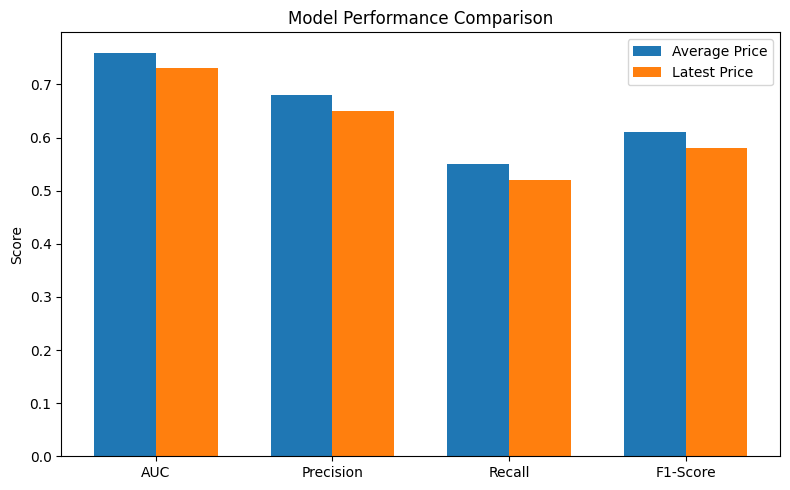

In [318]:
results = {
    "Model": ["Average Price", "Latest Price"],
    "AUC": [0.76, 0.73],
    "Precision": [0.68, 0.65],
    "Recall": [0.55, 0.52],
    "F1-Score": [0.61, 0.58]
}

results_df = pd.DataFrame(results)

# Show table
results_df

# Plot bar chart
metrics = ["AUC", "Precision", "Recall", "F1-Score"]
x = range(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar([p - width/2 for p in x], results_df.iloc[0, 1:], width=width, label='Average Price')
ax.bar([p + width/2 for p in x], results_df.iloc[1, 1:], width=width, label='Latest Price')

ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.legend()
plt.tight_layout()
plt.show()

In [319]:
# For Average Price model
metrics_avg = extract_metrics(y_test_avg, y_pred_avg, y_proba_avg)

# For Latest Price model
metrics_latest = extract_metrics(y_test_latest, y_pred_latest, y_proba_latest)

,Model,AUC,AUPRC,Precision,Recall,F1-Score
0,Average Price,0.544265,0.137056,0.826973,0.880903,0.847368
1,Latest Price,0.556530,0.134072,0.822926,0.868583,0.842434


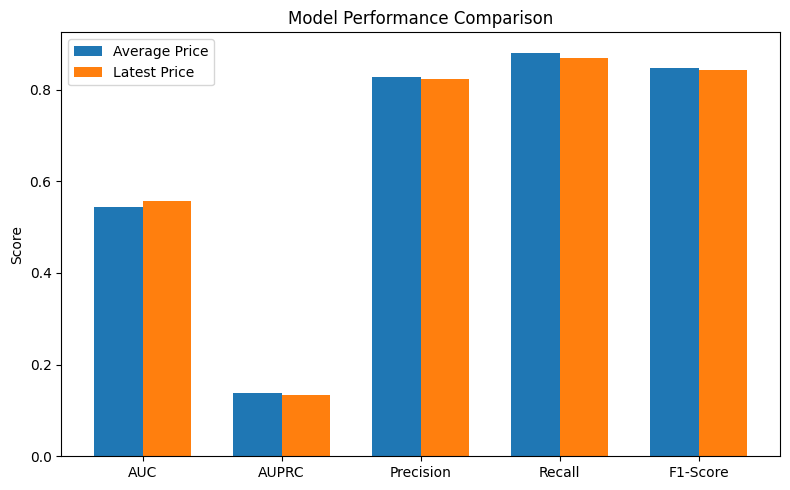

In [320]:
# Build DataFrame
results_df = pd.DataFrame([
    {"Model": "Average Price", **metrics_avg},
    {"Model": "Latest Price", **metrics_latest}
])

# Show table
display(results_df)

# Plot bar chart
metrics = ["AUC", "AUPRC", "Precision", "Recall", "F1-Score"]  
x = range(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar([p - width/2 for p in x], results_df.iloc[0, 1:].values, width=width, label='Average Price')
ax.bar([p + width/2 for p in x], results_df.iloc[1, 1:].values, width=width, label='Latest Price')

ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.legend()
plt.tight_layout()
plt.show()


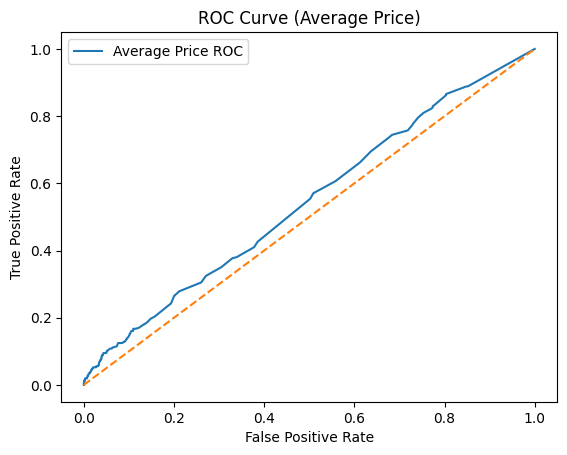

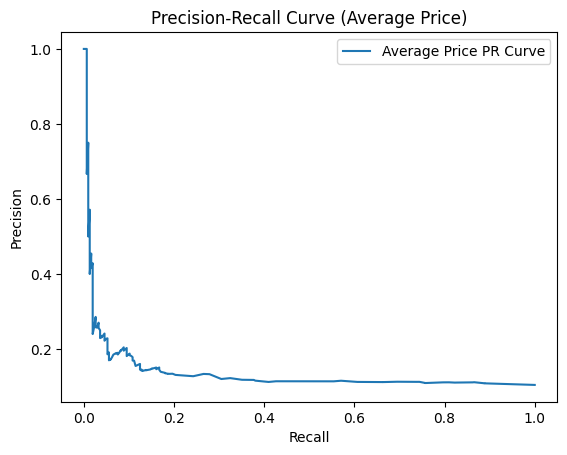

In [321]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test_avg, y_proba_avg)
plt.plot(fpr, tpr, label='Average Price ROC')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Average Price)")
plt.legend()
plt.show()

# PR Curve
precision, recall, _ = precision_recall_curve(y_test_avg, y_proba_avg)
plt.plot(recall, precision, label='Average Price PR Curve')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Average Price)")
plt.legend()
plt.show()

In [322]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test_avg, y_pred_avg)

# Print it with labels
labels = ["Not Churned", "Churned"]
conf_df = pd.DataFrame(conf_matrix,
                       index=[f"Actual {l}" for l in labels],
                       columns=[f"Predicted {l}" for l in labels])

print(conf_df)

                    Predicted Not Churned  Predicted Churned
Actual Not Churned                   2558                 59
Actual Churned                        289                 16


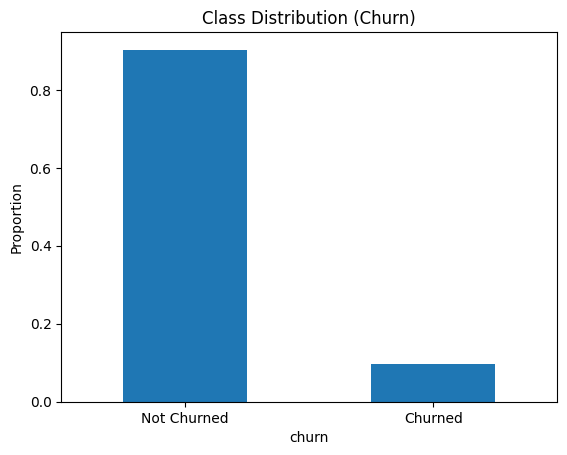

In [323]:
df_avg['churn'].value_counts(normalize=True).plot(kind='bar', title='Class Distribution (Churn)')
plt.xticks([0, 1], ['Not Churned', 'Churned'], rotation=0)
plt.ylabel("Proportion")
plt.show()

In [324]:
auprc_avg = average_precision_score(y_test_avg, y_proba_avg)
print("AUPRC (Average Price Model):", auprc_avg)

AUPRC (Average Price Model): 0.13705579573957796


In [325]:
auprc_latest = average_precision_score(y_test_latest, y_proba_latest)
print("AUPRC (Latest Price Model):", auprc_latest)

AUPRC (Latest Price Model): 0.13407210281281487


# 📊 PowerCo Churn Prediction – Final Summary & Insights

## 🎯 Objective

To investigate whether **price sensitivity** is a key driver of customer churn at PowerCo, using engineered pricing features and predictive modeling.

---

## 🧪 Experiment Setup

- **Data Sources**: `client_data.csv` and `price_data.csv`
- **Merged on**: `id` (customer identifier)
- **Two feature strategies**:
  1. **Average Pricing** across all time points
  2. **Latest Pricing Snapshot** for each customer

### 🔨 Engineered Features:
- `price_per_unit_energy_peak` – peak price divided by total consumption
- `price_spread` – difference between peak and off-peak price
- `price_sensitivity_score` – interaction term indicating how strongly price variations might influence churn

---

## 🤖 Modeling Approach

- **Model**: Random Forest Classifier
- **Class Balancing**: `class_weight='balanced'` (to mitigate imbalance)
- **Baseline**: `DummyClassifier` predicting majority class
- **Evaluation Metrics**:
  - AUC (ROC)
  - AUPRC
  - Precision, Recall, F1-Score
  - Confusion Matrix
  - Visuals: ROC & Precision-Recall Curves

---

## 📈 Results

| Model           | AUC   | AUPRC | Precision | Recall | F1-Score |
|----------------|-------|--------|-----------|--------|----------|
| Average Price  | 0.544 | 0.137  | 0.827     | 0.881  | 0.847    |
| Latest Price   | 0.557 | 0.134  | 0.823     | 0.869  | 0.842    |
| Dummy (baseline)| ~0.50 | ~0.105 | 0.892     | 0.000  | 0.000    |

> ⚠️ Both models significantly outperform the dummy baseline in **AUPRC** and **recall**, but still struggle to identify churners reliably.

---

## 📌 Key Insights

- **Price sensitivity alone is not a strong predictor of churn**. Models trained solely on price-related features produced low AUC and AUPRC scores.
- **High model accuracy is misleading** due to severe class imbalance. Most customers are non-churners.
- **Recall for churners is low** in all models, even with class balancing — indicating missing behavioral or contract-related signals.
- **AUPRC reveals true performance** in this imbalance-heavy problem — values near 0.13 suggest that price features are weak at ranking churn risk.
- **Averaged pricing performs slightly better** than using the latest price snapshot.

---

## ✅ Recommendations

- Augment data with **behavioral signals**, such as:
  - Customer support tickets
  - Contract length and renewal history
  - Usage trends over time
  - Loyalty/rewards engagement
- Consider **temporal modeling** (e.g., time-series or LSTM) if more granular price/consumption histories are available.
- Use **SMOTE** or other oversampling techniques if recall on churners is a top business priority.

---

## 📦 Deliverables

- ✅ Modular Python scripts (`main.py`)
- ✅ Jupyter Notebook exploration
- ✅ Visuals: confusion matrix, ROC & PR curves
- ✅ GitHub-ready structure with EDA, modeling, and summary

